In [1]:
import os
import shutil
import warnings

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torchaudio

warnings.filterwarnings(action="ignore")
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import json

import geopandas
import librosa
import librosa.display
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import soundfile
import tensorflow as tf
import tensorflow_addons as tfa
import torch

%matplotlib inline
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from torchaudio.transforms import MelSpectrogram
from tqdm import tqdm

from src.MEL_Gen import MEL_Gen, Mel_Provider
from src.prepare_dataset import (
    choose_ids,
    make_dict_birds,
    make_intervals,
    make_intervals_upsampling,
    prepare_dataset,
)

In [2]:
SEED = 42
IMG_SIZE = 260
SAMPLE_RATE = 32000
N_FFT = 2048
SIGNAL_LENGTH = 5
FREQ_MIN = 0
FREQ_MAX = 16000
WIN_LENGHT = 1024
BATCH_SIZE = 300
list_drop = [
    "XC509721.ogg",
    "XC428067.ogg",
    "XC523831.ogg",
    "XC523960.ogg",
    "XC237870.ogg",
    "XC129924.ogg",
    "XC576851.ogg",
    "XC579430.ogg",
    "XC590621.ogg",
]

In [3]:
final = pd.read_csv("/app/_data/labels_nocall/nocall_predictions.csv")
nocall = pd.read_csv("/app/_data/labels_nocall/all_nocalls.csv")

In [4]:
all_audio_init = pd.read_csv("/app/_data/all_audio_initial.csv")
all_audio = all_audio_init.query("filename not in @list_drop").reset_index(drop=True)
all_audio = all_audio.query("year >=1980 and year<=2021").reset_index(drop=True)

all_audio.shape

(65128, 24)

# dict_birds and weights

In [5]:
dict_birds, all_audio = make_dict_birds(all_audio)

In [6]:
len(dict_birds)

398

In [7]:
# os.mkdir("/app/_data/models/from_nocall/Eff2_1/")

In [8]:
file_json = open("/app/_data/models/from_nocall/Eff2_1/dict_birds.json", "w")
json.dump(dict_birds, file_json)
file_json.close()

In [9]:
dict_weights = (1 / all_audio["primary_label"].value_counts()).to_dict()
all_audio["class_weights"] = all_audio["primary_label"].replace(dict_weights)
# all_audio["class_weights"] = all_audio["class_weights"] * all_audio["rating"]

In [10]:
all_audio = all_audio[all_audio["rating"] >= 3]

## calls

In [11]:
drop_list_final = final[(final["bird"] == 1) & (final["nocall"] == 1)][
    "row_id"
].tolist()

In [12]:
final = final.query("row_id not in @drop_list_final")
final = final.query("bird == 1")


In [13]:
final = final.merge(
    all_audio[["filename", "primary_label", "class_weights", 'duration']], on="filename", how="left"
)

In [14]:
final = final.dropna(axis=0)
final = final.drop(['nocall', 'bird'], axis=1)

In [15]:
dict_w = pd.DataFrame((1/final['filename'].value_counts()))
dict_w.columns=['weights']
dict_w['filename'] = dict_w.index

In [16]:
final = final.merge(dict_w, on='filename', how='left')

In [17]:
final_sample = final.sample(1000000, weights="weights", random_state=SEED)
final_sample = final_sample.sample(300000, weights="class_weights", random_state=SEED)

In [18]:
final_sample['primary_label'].value_counts()

normoc     1405
bncfly     1300
houspa     1288
yebcha     1274
houwre     1273
           ... 
hofwoo1     131
whcpar      114
crfpar      109
wegspa1      48
stvhum2      47
Name: primary_label, Length: 397, dtype: int64

In [19]:
final_sample['filename'].value_counts()

XC285559.ogg    46
XC153986.ogg    37
XC375514.ogg    37
XC127999.ogg    35
XC189428.ogg    35
                ..
XC388701.ogg     1
XC118083.ogg     1
XC129968.ogg     1
XC193762.ogg     1
XC459671.ogg     1
Name: filename, Length: 49309, dtype: int64

In [20]:
final_sample

,row_id,filename,end_sec,primary_label,class_weights,duration,weights
1478303,XC154276_60_0,XC154276.ogg,60.0,pabspi1,0.006711,109.401906,0.009524
716938,XC295597_113_0,XC295597.ogg,113.0,cubthr,0.002000,207.181000,0.004950
649944,XC192253_23_0,XC192253.ogg,23.0,comrav,0.002004,31.308844,0.043478
2105012,XC124521_168_0,XC124521.ogg,168.0,wewpew,0.004630,170.698250,0.006024
1980898,XC250541_45_0,XC250541.ogg,45.0,thswar1,0.008333,48.001094,0.100000
...,...,...,...,...,...,...,...
1252141,XC195600_31_0,XC195600.ogg,31.0,macwar,0.005155,147.188031,0.006993
1682673,XC376265_17_0,XC376265.ogg,17.0,rubrob,0.007634,28.983969,0.041667
766755,XC124644_75_0,XC124644.ogg,75.0,dusfly,0.008850,82.430500,0.014286
1880800,XC327617_36_0,XC327617.ogg,36.0,stbori,0.007812,47.008437,0.023256


In [21]:
final_sample = final_sample[
    ["row_id", "filename", "end_sec", "primary_label", "class_weights"]
].merge(
    all_audio[
        [
            "filename",
            "secondary_labels",
            "label_id",
            "secondary_labels_id",
            "duration",
            "rating",
            "year",
            "file_path",
            "sin_month",
            "cos_month",
            "sin_longitude",
            "cos_longitude",
            "latitude",
            "norm_latitude",
        ]
    ],
    on="filename",
    how="left",
)

In [22]:
final_sample = final_sample.sample(frac=1, random_state=SEED).reset_index(drop=True)

In [23]:
final_sample["primary_label"].value_counts()

normoc     1405
bncfly     1300
houspa     1288
yebcha     1274
houwre     1273
           ... 
hofwoo1     131
whcpar      114
crfpar      109
wegspa1      48
stvhum2      47
Name: primary_label, Length: 397, dtype: int64

# nocall

In [24]:
nocall = nocall.drop_duplicates()

In [25]:
nocall["file_path"] = nocall["file_path"].str.replace("birdclef-2021/", "")

In [26]:
nocall = nocall[~nocall['file_path'].str.contains('train_soundscapes')].reset_index(drop=True)

In [27]:
soundscapes_nocall =all_audio[all_audio['file_path'].str.contains('train_soundscapes')]
soundscapes_nocall = soundscapes_nocall[soundscapes_nocall['primary_label']=='nocall']

In [28]:
dict_w = (1/nocall['filename'].value_counts()).to_dict()
nocall['weights'] = nocall['filename'].replace(dict_w)

In [29]:
nocall_sample = nocall.sample(1000, random_state=SEED,  weights='weights')

In [30]:
nocall_sample['filename'].value_counts()

XC196022.ogg    13
XC575220.ogg    12
XC217786.ogg    10
XC436935.ogg    10
XC237885.ogg    10
                ..
XC564545.ogg     1
XC132192.ogg     1
XC291092.ogg     1
XC391155.ogg     1
XC259210.ogg     1
Name: filename, Length: 192, dtype: int64

In [31]:
nocall_sample = nocall_sample.merge(
    all_audio[
        [
            "filename",
            "rating",
            "year",
            "sin_month",
            "cos_month",
            "sin_longitude",
            "cos_longitude",
            "latitude",
            "norm_latitude",
            'class_weights'
        ]
    ],
    on="filename",
    how="left",
)

In [32]:
nocall_sample = nocall_sample[['filename', 'row_id', 'start_sec', 'end_sec', 'file_path',
       'duration', 'rating', 'year', 'sin_month', 'cos_month',
       'sin_longitude', 'cos_longitude', 'latitude', 'norm_latitude',
       'class_weights']]
soundscapes_nocall = soundscapes_nocall[['filename', 'row_id', 'start_sec', 'end_sec', 'file_path',
       'duration', 'rating', 'year', 'sin_month', 'cos_month',
       'sin_longitude', 'cos_longitude', 'latitude', 'norm_latitude',
       'class_weights']]

In [33]:
soundscapes_nocall['duration']=600

In [34]:
all_nocall = pd.concat([nocall_sample, soundscapes_nocall], axis=0, ignore_index=True)

In [35]:
all_nocall["label_id"] = dict_birds["nocall"]
all_nocall["secondary_labels_id"] = np.nan
all_nocall = all_nocall.sample(frac=1, random_state=SEED).reset_index(drop=True)

In [36]:
all_nocall.isna().sum()

filename                  0
row_id                    0
start_sec                 0
end_sec                   0
file_path                 0
duration                  0
rating                    0
year                      0
sin_month                 0
cos_month                 0
sin_longitude             0
cos_longitude             0
latitude                  0
norm_latitude             0
class_weights             0
label_id                  0
secondary_labels_id    2529
dtype: int64

In [37]:
all_nocall['year'].describe()

count    2529.000000
mean     2016.058917
std         4.660729
min      1989.000000
25%      2015.000000
50%      2017.000000
75%      2019.000000
max      2021.000000
Name: year, dtype: float64

# concat

In [38]:
final_audio = (
    pd.concat(
        [final_sample, all_nocall],
        axis=0,
        ignore_index=True,
    )
    .sample(frac=1, random_state=SEED)
    .reset_index(drop=True)
)
final_audio.shape

(302529, 19)

In [39]:
final_audio["primary_label"].value_counts().tail(20)

norsho     362
flrtan1    348
nrwswa     346
sander     335
amewig     329
buwtea     324
higmot1    303
rebsap     302
grhcha1    244
bucmot2    232
rehbar1    227
rthhum     211
gretin1    195
runwre1    169
heptan     169
hofwoo1    131
whcpar     114
crfpar     109
wegspa1     48
stvhum2     47
Name: primary_label, dtype: int64

#  upsampling


In [40]:
rare_birds = list(final_audio["primary_label"].value_counts().tail(20).index.values)

In [41]:
df = pd.DataFrame(columns=["end_sec", "class_weights", "filename"])
for bird in rare_birds:
    rare_bird_filenames = (
    all_audio.query("primary_label ==@bird")["filename"].unique().tolist())
    rare_array = all_audio.query(
        "primary_label ==@bird and rating!=0 and rating!=6 and filename in @rare_bird_filenames"
    )[["filename", "duration", "class_weights"]].values
    intervals = make_intervals_upsampling(rare_array)
    df = pd.concat([df, intervals], axis=0)

df

,end_sec,class_weights,filename
XC110104_5_0,5.00,0.013158,XC110104.ogg
XC110104_8_16,8.16,0.013158,XC110104.ogg
XC110104_11_33,11.33,0.013158,XC110104.ogg
XC110104_14_5,14.50,0.013158,XC110104.ogg
XC110104_17_67,17.67,0.013158,XC110104.ogg
...,...,...,...
XC617300_29_65,29.65,0.125000,XC617300.ogg
XC617300_29_83,29.83,0.125000,XC617300.ogg
XC617300_30_01,30.01,0.125000,XC617300.ogg
XC617300_30_19,30.19,0.125000,XC617300.ogg


In [42]:
df['filename'].unique().shape

(509,)

In [43]:
df["row_id"] = df.index
df = df.merge(
    all_audio[
        [
            "filename",
            "primary_label",
            "secondary_labels",
            "label_id",
            "secondary_labels_id",
            "duration",
            "rating",
            "year",
            "file_path",
            "frames",
            "sin_month",
            "cos_month",
            "sin_longitude",
            "cos_longitude",
            "latitude",
            "norm_latitude",
            "date",
        ]
    ],
    on="filename",
    how="left",
)
df["end_sec"] = df["end_sec"].apply(lambda x: x if x > 5 else 5)
df["start_sec"] = df["end_sec"] - 5

In [44]:
df['primary_label'].unique().shape

(20,)

In [45]:
final_audio = (
    pd.concat(
        [final_audio, df],
        axis=0,
        ignore_index=True,
    )
    .sample(frac=1, random_state=SEED)
    .reset_index(drop=True)
)
final_audio.shape

final_audio["primary_label"].value_counts().tail(20)

(313824, 21)

comgol     460
rugdov     454
belkin1    452
baleag     449
semplo     440
whimbr     440
tropew1    435
blctan1    430
pavpig2    422
gbbgul     415
wooduc     403
scrtan1    401
lotduc     392
brwpar1    392
commer     392
grnher     387
sthwoo1    381
leasan     374
goowoo1    371
cacgoo1    368
Name: primary_label, dtype: int64

In [46]:
train, valid = train_test_split(final_audio, train_size=0.8, random_state=SEED)
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

# MEL_Gen

In [47]:
NUM_CLASSES = len(dict_birds)
BATCH_SIZE = 224

In [48]:
mel_pr = Mel_Provider(
    n_fft=N_FFT,
    win_length=WIN_LENGHT,
    n_mels=IMG_SIZE,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    min_frequency=FREQ_MIN,
    max_frequency=FREQ_MAX,
    signal_lenght=SIGNAL_LENGTH,
)

In [49]:
# shutil.rmtree('/app/_data/npy/short_mels_224_uint8/', ignore_errors=True)

In [50]:
gen_train = MEL_Gen(
    df=train,
    n_mels=IMG_SIZE,
    seed=SEED,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    n_classes=NUM_CLASSES,
    signal_lenght=SIGNAL_LENGTH,
    mel_provider=mel_pr,
    wave_dir="/app/_data/npy/waves_npy/",
    short_mel_dir="/app/_data/npy/short_mels_260_uint8/",
    convert_to_rgb=True,
    shuffle=True,
    return_primary_labels=False,
    return_concat_labels=True,
    augment=False,
    img_dtype="uint8",
)
gen_valid = MEL_Gen(
    df=valid,
    n_mels=IMG_SIZE,
    seed=SEED,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    n_classes=NUM_CLASSES,
    signal_lenght=SIGNAL_LENGTH,
    mel_provider=mel_pr,
    wave_dir="/app/_data/npy/waves_npy/",
    short_mel_dir="/app/_data/npy/short_mels_260_uint8/",
    convert_to_rgb=True,
    shuffle=False,
    return_primary_labels=False,
    return_concat_labels=True,
    augment=False,
    img_dtype="uint8",
)

In [51]:
a = gen_train.__getitem__(0)

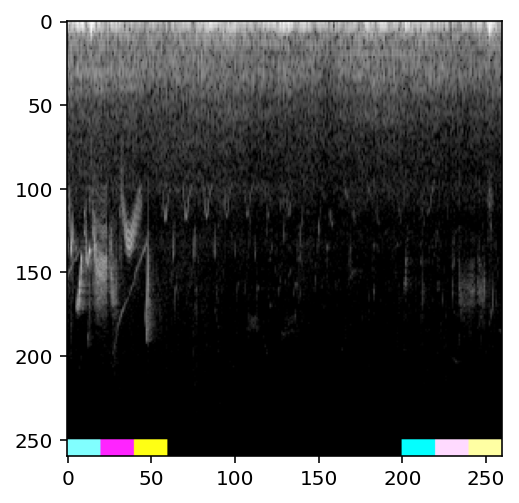

In [52]:
plt.imshow(a[0][0])

# model

In [53]:
def get_model():
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model = keras.applications.EfficientNetB2(
        weights="imagenet", include_top=False
    )
    x = base_model(inputs)
    x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = keras.layers.Flatten(name="flatten")(x)
    outputs = keras.layers.Dense(NUM_CLASSES, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        loss="binary_crossentropy",
        optimizer=Adam(lr=0.0005),
        metrics=[
            "acc",
            keras.metrics.Recall(),
            keras.metrics.Precision(),
            tfa.metrics.F1Score(num_classes=NUM_CLASSES, average="micro"),
        ],
    )
    return model


policy = keras.mixed_precision.experimental.Policy("mixed_float16")
keras.mixed_precision.experimental.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6


In [54]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_f1_score",
        patience=12,
        restore_best_weights=True,
        verbose=1,
        mode="max",
    ),
    keras.callbacks.ModelCheckpoint(
        "/app/_data/models/from_nocall/Eff2_1/Eff2_1.h5",
        monitor="val_f1_score",
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode="max",
        save_freq="epoch",
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_f1_score",
        factor=0.9,
        patience=5,
        verbose=1,
        mode="max",
        min_delta=1e-4,
        min_lr=0.00000001,
    ),
    keras.callbacks.TensorBoard(
        log_dir="/app/.tensorboard/Eff2_1_nc/", histogram_freq=0
    ),
    keras.callbacks.experimental.BackupAndRestore(
        "/app/_data/models/from_nocall/Eff2_1/backup/"
    ),
    keras.callbacks.TerminateOnNaN(),
]

In [ ]:
model = get_model()
history = model.fit(
    gen_train,
    validation_data=gen_valid,
    epochs=100,
    steps_per_epoch=train.shape[0] // BATCH_SIZE,
    validation_steps=valid.shape[0] // BATCH_SIZE,
    verbose=1,
    workers=20,
    max_queue_size=50,
    callbacks=callbacks,
)

Epoch 26/100
   1/1120 [..............................] - ETA: 0s - loss: 0.0028 - acc: 0.9821 - recall: 0.5987 - precision: 0.9965 - f1_score: 0.8076WARNING:tensorflow:From /usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1120/1120 [==============================] - ETA: 0s - loss: 0.0029 - acc: 0.9647 - recall: 0.5931 - precision: 0.9854 - f1_score: 0.8089
Epoch 00026: val_f1_score improved from -inf to 0.80457, saving model to /app/_data/models/from_nocall/Eff2_1/Eff2_1.h5
1120/1120 [==============================] - 1004s 897ms/step - loss: 0.0029 - acc: 0.9647 - recall: 0.5931 - precision: 0.9854 - f1_score: 0.8089 - val_loss: 0.0030 - val_acc: 0.9590 - val_recall: 0.6004 - val_precision: 0.9796 - val_f1_score: 0.8046
Epoch 27/100
1120/1120 [==============================] - ETA: